# Random Forest, Gradient Boosting & XGBoost on Palmer Penguins


In [1]:
# install XGBoost package
!pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

## Load & Inspect Dataset

We load the Palmer Penguins dataset via Seaborn.

In [3]:
df = sns.load_dataset("penguins")
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (344, 7)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


## Exploratory Data Analysis (EDA)

Inspect the following:

1. Class balance
2. Missing values
3. Feature distribution
4. Pairplot

After completing these we will come back together and discuss.

In [4]:
# 1. Class balance
print(df['species'].value_counts())

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64


In [5]:
# 2. Missing values
print(df.isnull().sum())

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64


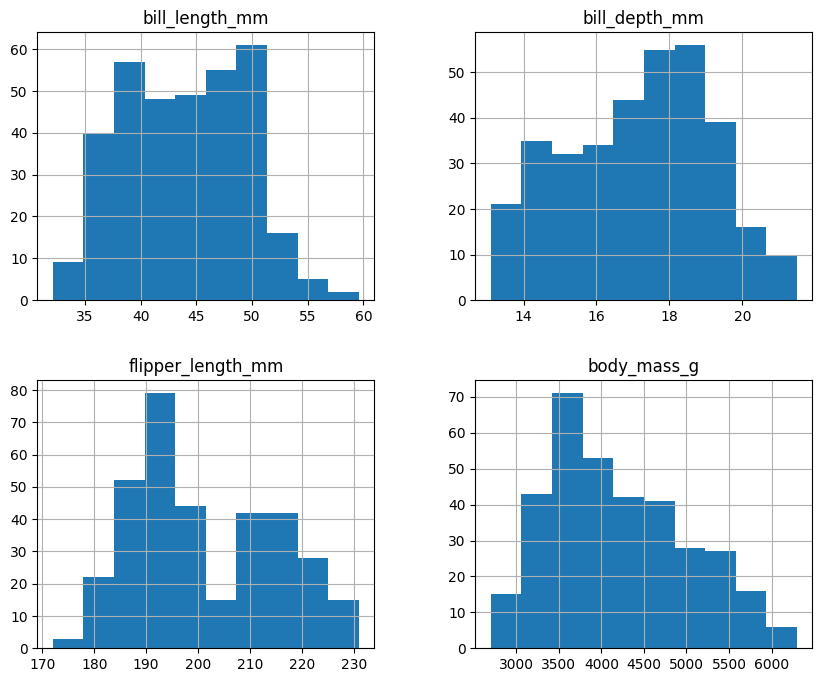

In [6]:
# 3. Feature distribution
df.hist(figsize=(10, 8))
plt.show()

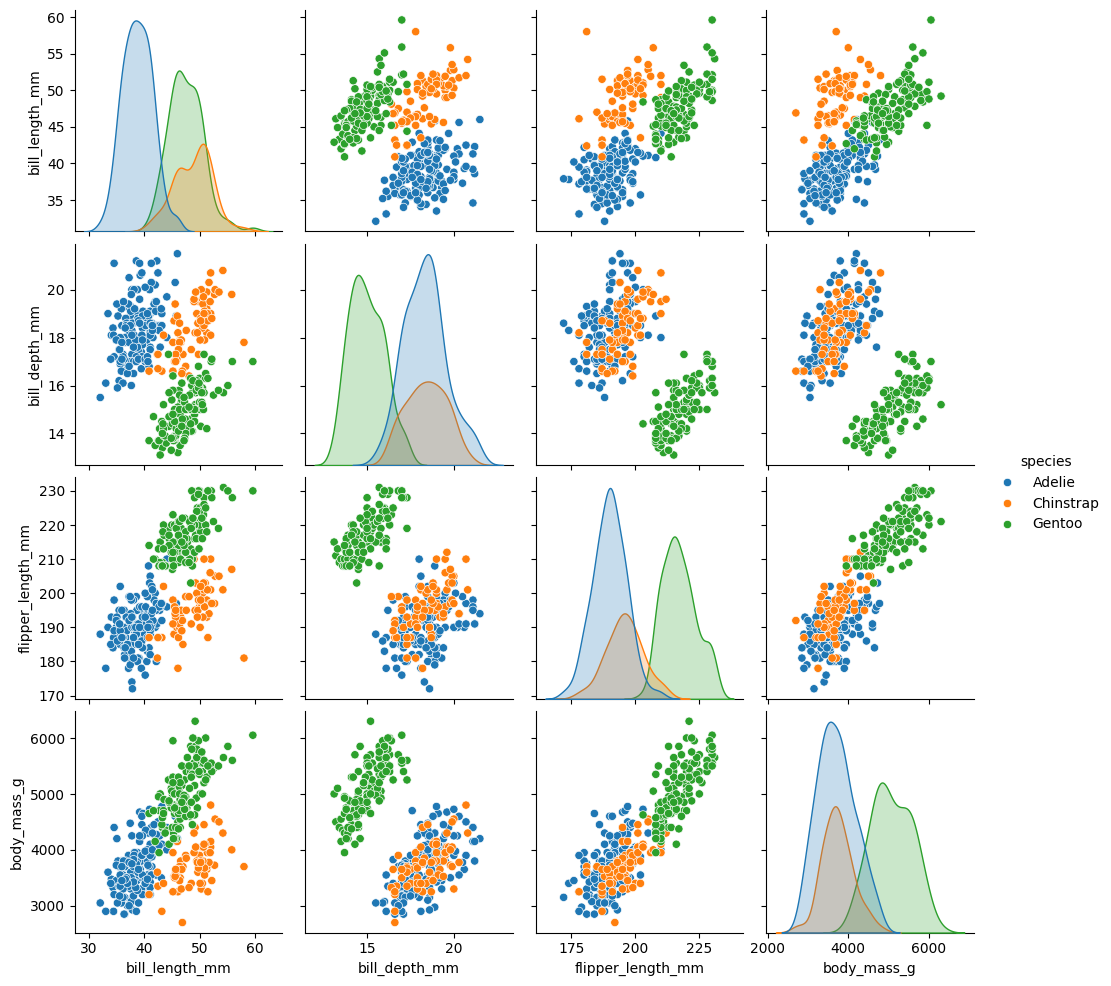

In [7]:
# 4. Pairplot
sns.pairplot(df, hue='species')
plt.show()

## Preprocessing
1. Drop all rows with missing values
2. One-hot encode categorical features (island, sex, species)
3. Define X, y (we'll do a binary prediction: Gentoo vs. others)
4. Train/test split (80/20, stratified)

In [8]:
# Drop missing
df2 = df.dropna().reset_index(drop=True)
print("After dropna:", df2.shape)

# # USE THIS FOR BINARY Gentoo VERSUS REST CLASSIFICATION
# # One-hot encode
# df_enc = pd.get_dummies(df2, columns=['island','sex','species'], drop_first=True)

# # Features and target
# X = df_enc.drop(columns=['species_Gentoo'])
# y = df_enc['species_Gentoo']  # 1 = Gentoo, 0 = others

# One-hot encode non-target categoricals only
df_enc = pd.get_dummies(df2, columns=['island', 'sex'], drop_first=True)

# Multiclass target: use label encoding
le = LabelEncoder()
y = le.fit_transform(df2['species'])  # Adelie=0, Chinstrap=1, Gentoo=2

X = df_enc.drop(columns=['species'])  # Keep everything else

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape)

After dropna: (333, 7)
Train: (266, 7) Test: (67, 7)


**Interpretation:**
We now have a clean numeric dataset, with a binary target.  Training set is 80% of data; test set is 20%.

## Model Training

Instantiate and fit three models:

*   RandomForestClassifier
*   GradientBoostingClassifier
*   XGBClassifier (if available)

In [9]:
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}
models['XGBoost'] = xgb.XGBClassifier(
    eval_metric='logloss', random_state=42
)

for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    print(f"Trained {name}")

Trained RandomForest
Trained GradientBoosting
Trained XGBoost


## Model Evaluation & Comparison

**Test-Set Performance**

Evaluate each model:

In [10]:
results = {}
for name, mdl in models.items():
    preds = mdl.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    results[name] = acc


RandomForest Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        24

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67

Confusion Matrix:
 [[29  0  0]
 [ 0 14  0]
 [ 0  0 24]]

GradientBoosting Accuracy: 0.9701
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        29
           1       1.00      1.00      1.00        14
           2       1.00      0.92      0.96        24

    accuracy                           0.97        67
   macro avg       0.98      0.97      0.97        67
weighted avg       0.97      0.97      0.97        67

Confusion Matrix:
 [[29  0  0]
 [ 0 14  0]
 [ 2  0 22]]

XGBoost Accuracy: 1.0000
              precision    recall 

**Accuracy Comparison Chart**

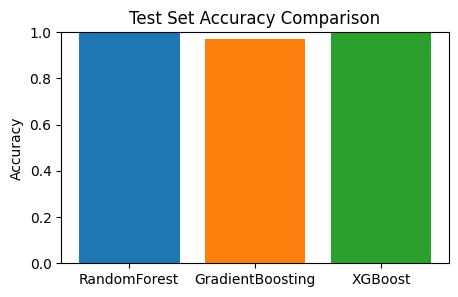

In [11]:
plt.figure(figsize=(5,3))
plt.bar(results.keys(), results.values(), color=['C0','C1','C2'][:len(results)])
plt.ylim(0,1)
plt.title("Test Set Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

**Hyperparameter Tuning & Cross-Validation**

We'll run a *GridSearchCV* for each model on a small hyperparameter grid, using 5-fold CV on the *training set*. Then we'll report best params, retrain, and evaluate on test.

We'll test combinations of tree counts, depths, and learning rates to find the best settings for each model via cross-validation.

In [12]:
from sklearn.model_selection import GridSearchCV

# 6.3.1 RF tuning
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5, 10],
}
gs_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1
)
gs_rf.fit(X_train, y_train)
print("Best RF params:", gs_rf.best_params_)

# 6.3.2 GB tuning
param_grid_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
gs_gb = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_gb, cv=5, scoring='accuracy', n_jobs=-1
)
gs_gb.fit(X_train, y_train)
print("Best GB params:", gs_gb.best_params_)

# 6.3.3 XGB tuning
param_grid_xgb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
gs_xgb = GridSearchCV(
    xgb.XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1
)
gs_xgb.fit(X_train, y_train)
print("Best XGB params:", gs_xgb.best_params_)

Best RF params: {'max_depth': None, 'n_estimators': 50}
Best GB params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Best XGB params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}


## Evaluate Tuned Models

Retrain with best hyperparameters and evaluate on the test set:

RF_tuned Accuracy: 1.0000
GB_tuned Accuracy: 0.9254
XGB_tuned Accuracy: 0.9701


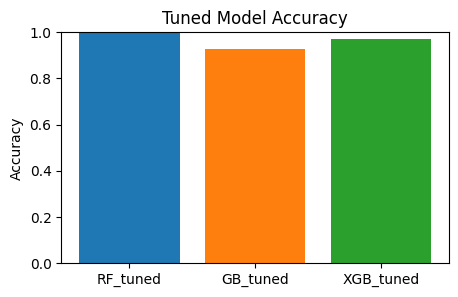

In [13]:
best_rf = gs_rf.best_estimator_
best_gb = gs_gb.best_estimator_
models_tuned = {
    'RF_tuned': best_rf,
    'GB_tuned': best_gb
}

models_tuned['XGB_tuned'] = gs_xgb.best_estimator_

tuned_results = {}
for name, mdl in models_tuned.items():
    preds = mdl.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"{name} Accuracy: {acc:.4f}")
    tuned_results[name] = acc

# Bar chart of tuned models
plt.figure(figsize=(5,3))
plt.bar(tuned_results.keys(), tuned_results.values(), color=['C0','C1','C2'][:len(tuned_results)])
plt.ylim(0,1)
plt.title("Tuned Model Accuracy")
plt.ylabel("Accuracy")
plt.show()

## Interpretability Visualizations

**Feature Importances**

We'll extract and plot the top 10 most important features for each model.  
Random Forest and GradientBoosting use `feature_importances_`; XGBoost will be handled separately below.


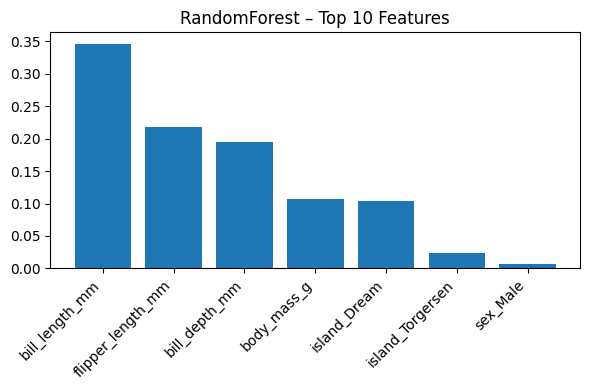

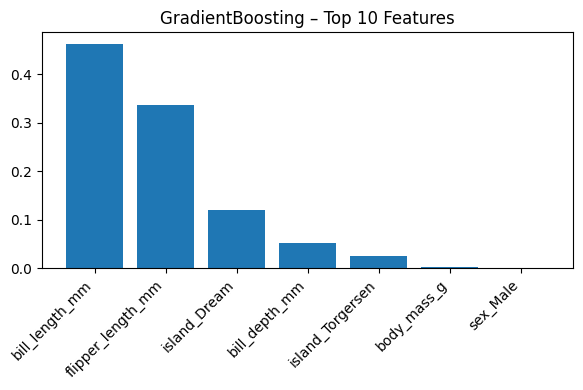

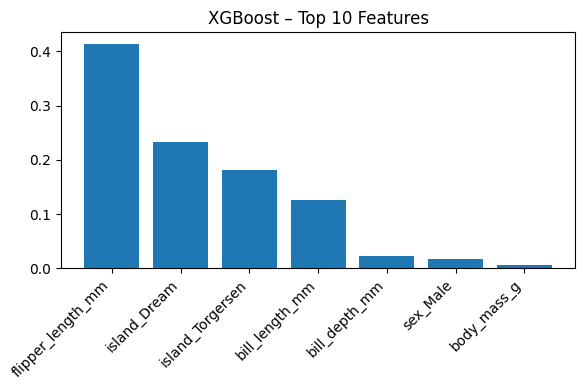

In [14]:
import matplotlib.pyplot as plt

for name, mdl in models.items():
    # get feature importances and sort
    imp = mdl.feature_importances_
    idx = np.argsort(imp)[::-1][:10]
    top_feats = X_train.columns[idx]

    plt.figure(figsize=(6,4))
    plt.title(f"{name} – Top 10 Features")
    plt.bar(range(len(idx)), imp[idx])
    plt.xticks(range(len(idx)), top_feats, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

**Interpretation**:

*   Each bar shows how heavily the model leans on that feature when making splits.
*   Compare heights across models to see who "bets" on which features most.
*   A wide spread (RF) vs. concentrated spikes (boosting) tells you about model focus.

## Partial Dependence Plots

Now for Gradient Boosting: we'll plot partial dependence of the two most important features, showing how the predicted probability of our target (Gentoo = 1) changes as you vary that feature, all else held constant.

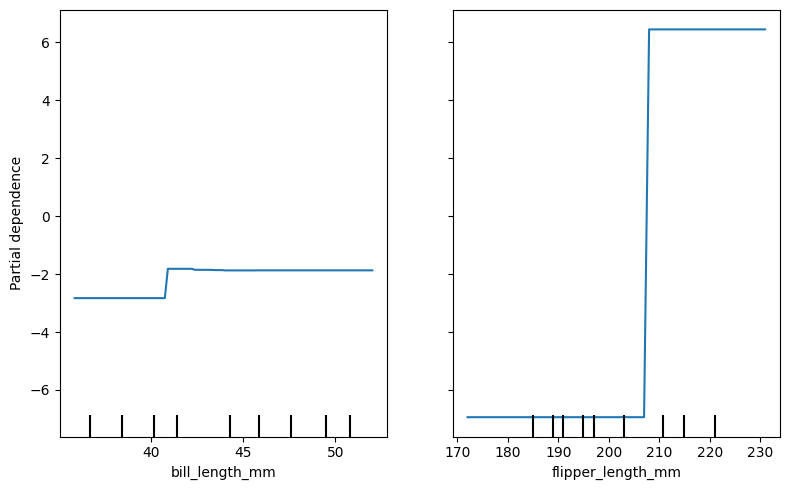

In [15]:
from sklearn.inspection import PartialDependenceDisplay

# identify top 2 GB features
gb = models['GradientBoosting']
imp_gb = gb.feature_importances_
gb_idx = np.argsort(imp_gb)[::-1]
top2 = [X_train.columns[i] for i in gb_idx[:2]]

fig, ax = plt.subplots(figsize=(8,5))
PartialDependenceDisplay.from_estimator(
    gb, X_train, top2,
    target=2,  # Class index for Gentoo (change for different species/classes)
    feature_names=X_train.columns, ax=ax
)
plt.tight_layout()
plt.show()

**Interpretation**:

*   Each curve shows the average predicted probability as one feature moves across its range.
*   A rising curve means higher values of that feature boost the chance of "Gentoo."
*   Flat regions mean the model is insensitive there.

### Interpreting the Partial Dependence Plots (PDP) for Gentoo

These plots show how the model's predicted score for **class 2 (Gentoo)** changes as we vary one feature at a time, keeping all other features fixed at their original values.

- For `flipper_length_mm`, the model's output **jumps sharply from negative to positive** around 207-210mm. This suggests that flippers longer than this threshold **strongly push the model toward predicting Gentoo**.
- For `bill_length_mm`, the model predicts **lower probability of Gentoo** across most values, with a very slight uptick around ~43mm — but overall this feature seems less impactful in isolation than flipper length.

**Partial dependence (y-axis)** reflects the model's **average raw logit score** for the *Gentoo* class. Values > 0 indicate increasing confidence in Gentoo, values < 0 lean toward Adelie/Chinstrap.

## XGBoost-Specific Plots

XGBoost provides two handy built-in plots:
1. Gain-based feature importance
2. Graphviz-style tree visualization for the first tree in the ensemble

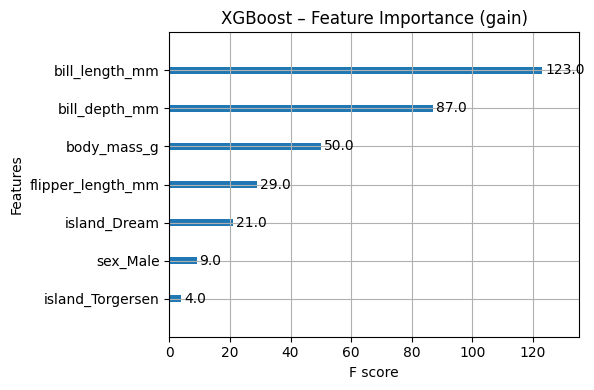

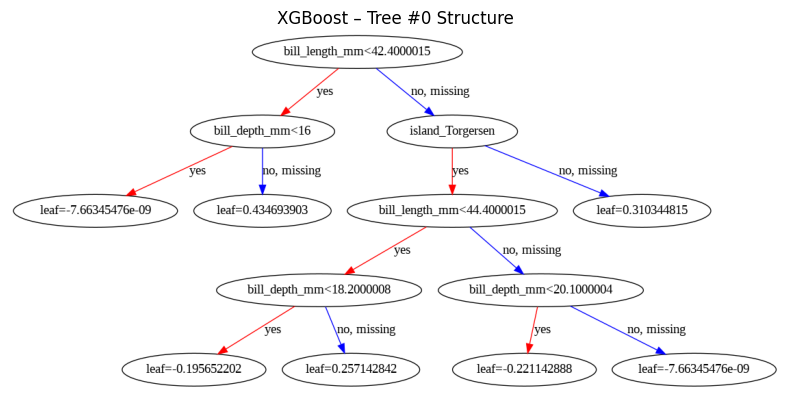

In [16]:
# 1) Gain‐based feature importance
fig, ax = plt.subplots(figsize=(6,4))
xgb.plot_importance(models['XGBoost'], max_num_features=10, ax=ax)
plt.title("XGBoost – Feature Importance (gain)")
plt.tight_layout()
plt.show()

# 2) Visualize tree #0
fig, ax = plt.subplots(figsize=(8,6))
xgb.plot_tree(models['XGBoost'], num_trees=0, ax=ax)
plt.title("XGBoost – Tree #0 Structure")
plt.tight_layout()
plt.show()

**Interpretation**:

*   Gain importance ranks features by how much they improve the split objective.
*   The tree graph shows actual split thresholds and leaf values—great for seeing one concrete example of how XGBoost partitions the space.

### Interpreting the XGBoost Feature Importance (Gain-Based)

This bar chart shows how much each feature **contributed to improving model accuracy** when used to split the data, across all classes.

- `bill_length_mm` and `bill_depth_mm` were by far the **most influential features** — when they were used in splits, they significantly reduced classification error.
- `flipper_length_mm` also contributed, but to a lesser extent than in the binary Gentoo-only case.
- Categorical features like `island_Dream` and `sex_Male` were used occasionally, while `island_Torgersen` had minor impact.

**Gain** measures total improvement in the model when a feature is used — not how often it appears, but how *valuable* it is when it does.

### Interpreting XGBoost - Tree #0 (Class 0 = Adelie)

This decision tree shows how the model adjusted its **logit score for class 0 (Adelie)** at boosting round 0.

- The first split is on `bill_length_mm < 42.4`. Samples with shorter bills are nudged toward Adelie.
- Subsequent splits refine the prediction using `bill_depth_mm` and island affiliation, with specific attention to values around 16-20mm in depth.
- The **leaf values** are raw score contributions for the Adelie class: negative scores reduce its probability, positive scores increase it.

Each sample follows a path down the tree based on feature values, and lands in a leaf that **updates its score for class 0 (Adelie)**.  
This is one of many trees — in each boosting round, separate trees update scores for each class.

## Predicted Probabilities

The above tree gives you information on Gentoo=1, however you can extract the predicted probabilities for each row of each class.

In [17]:
# Get class probabilities for each sample
xgb_model = models['XGBoost']
xgb_probs = xgb_model.predict_proba(X_test)

# Show probability predictions for first 5 samples
pd.DataFrame(xgb_probs, columns=xgb_model.classes_).head()

,0,1,2
0,0.000677,0.001489,0.997834
1,0.000619,0.998403,0.000977
2,0.999260,0.000404,0.000336
3,0.000677,0.001489,0.997834
4,0.000677,0.001489,0.997834


## Reflection Questions
1. Which model, tuned vs. untuned, performed best, and why?
- tuned XGBoost model performs the best in terms of accuracy on the test set
*Note: Tuned XGBoost often wins due to optimized tree count and regularization.*

2. How did hyperparameter tuning affect each model?
- led to improvements in test accuracy for all three models.
*Note: Tuning can boost test accuracy, but over-searching can overfit.*

3. How does cross-validation differ from a simple train/test split?
- CV splits the data into multiple folds. The model is trained on a subset of the folds and validated on the remaining fold. This process is repeated multiple times, with different folds used for validation, to get a more robust estimate of model performance.


4. When would you prefer a Random Forest over a tuned XGBoost?
- Random Forests can be faster to train, particularly when dealing with large datasets, as the trees are built independently


5. Why do you think the model that performed best did indeed perform the best?
- tuned XGBoost model likely performed the best due to Gradient Boosting, Regularization, Optimized Hyperparameters